# Необхідні бібліотеки та функції

In [1]:
# import libraries

from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar import svar_model

from statsmodels.tools.eval_measures import rmse, rmspe, meanabs

In [2]:
# useful functions

def mape(y_actual, y_predicted):
    result = np.mean(np.abs((y_actual - y_predicted)/y_actual)) * 100
    return result

def change_rate(series):
    series = np.array(series)
    rate = np.diff(series, )/series[:-1] * 100
    return rate

def test_stationarity(data):
    for factor in data.columns:
        adf_test = adfuller(data[[factor]]) #use augmented Dicky-Fuller test
        print(f'{factor}: pvalue = {adf_test[1]}')
        
def plot_series(data):
    for factor in data.columns:
        plt.figure(figsize=(15, 5))
        plt.plot(data[[factor]])
        plt.title(factor)
        plt.show() 

# Завантаження та підготовка даних

In [3]:
macrodata = pd.read_csv('macrodata.csv', delimiter=';', decimal=',', encoding='windows-1251')

In [4]:
macrodata.index = pd.date_range('2013-01', '2022-10', freq='M')
macrodata.columns

Index(['Date', 'CPI', 'Annual Inflation Rate', 'UK CPI', 'US CPI', 'EU CPI',
       'Inf Expect (Households)', 'Interest Rate', 'REER', 'NEER',
       'Gross Foreign Reserves', 'Net Foreign Reserves', 'Interv',
       'Domestic Gov Bonds'],
      dtype='object')

In [5]:
data = macrodata.dropna().copy()['2016':]
data = data.drop(['CPI', 'Date'], axis=1)

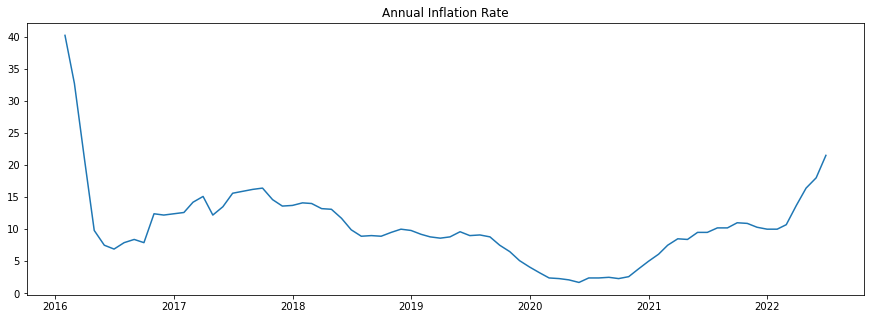

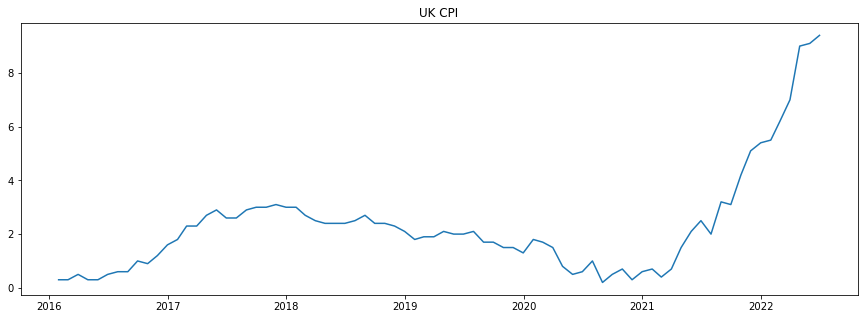

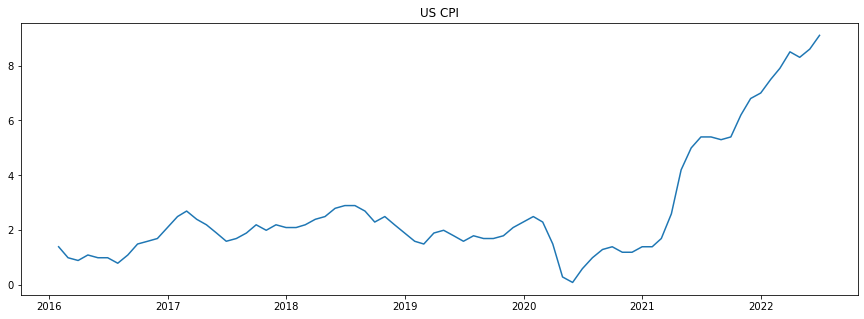

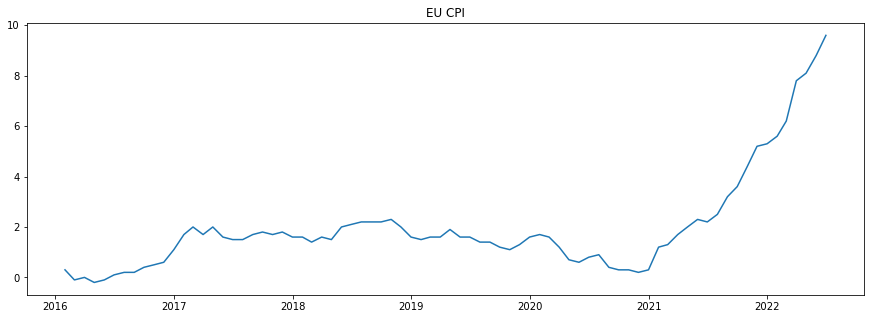

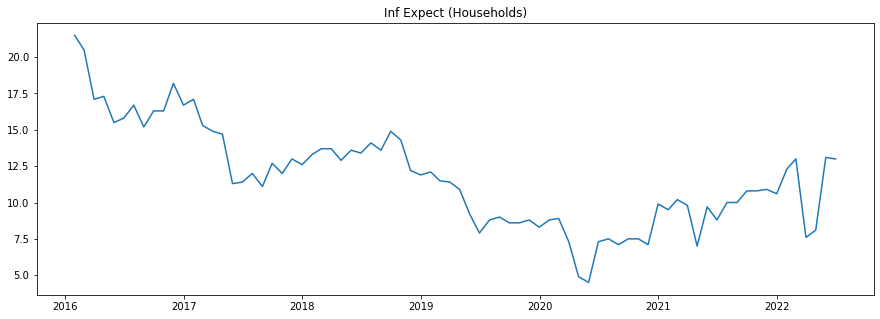

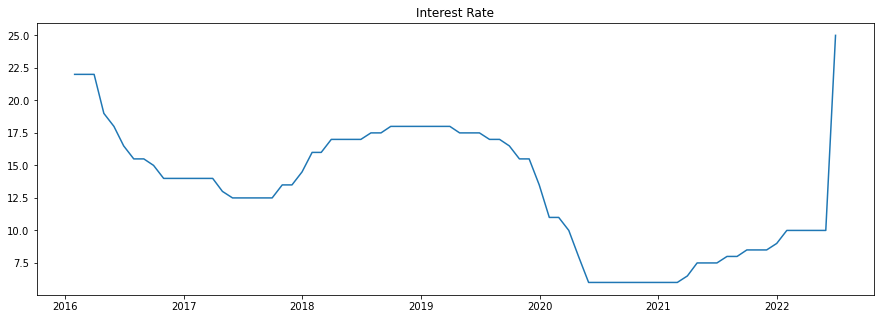

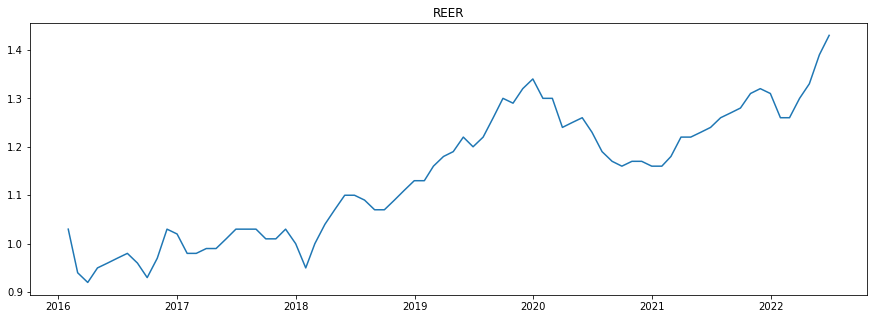

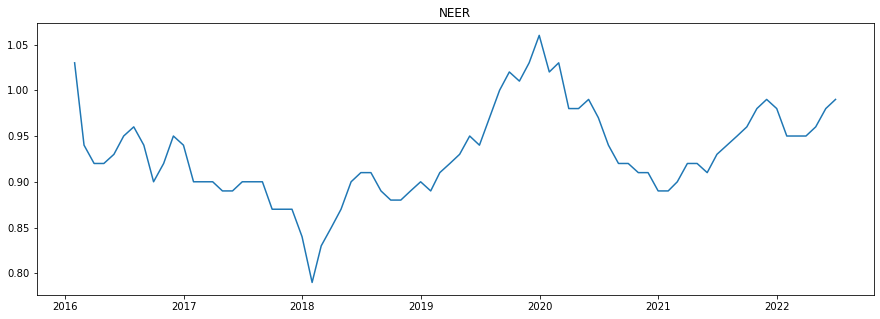

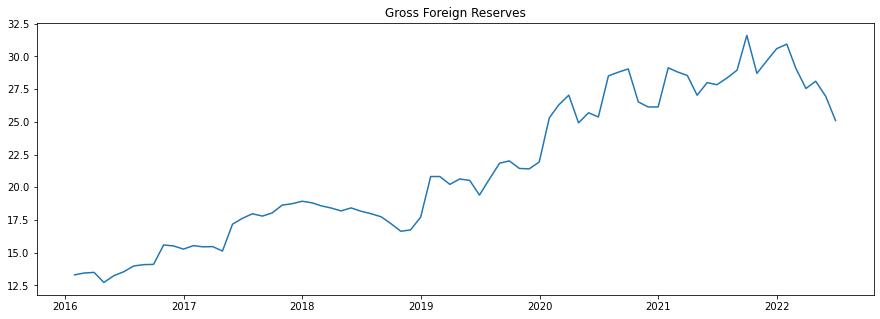

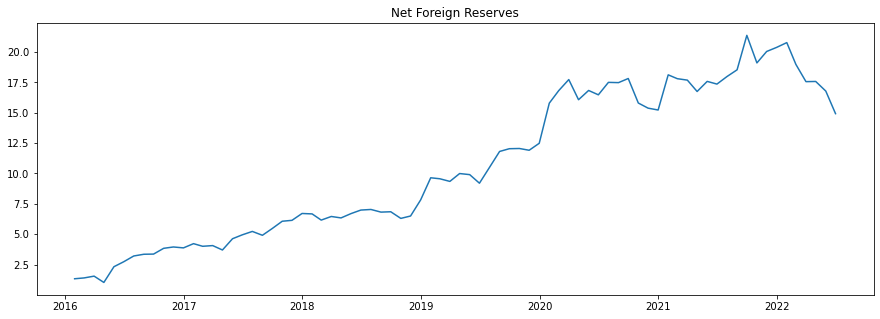

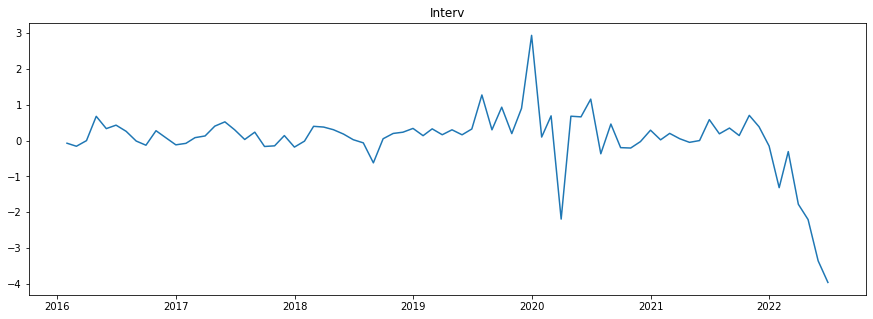

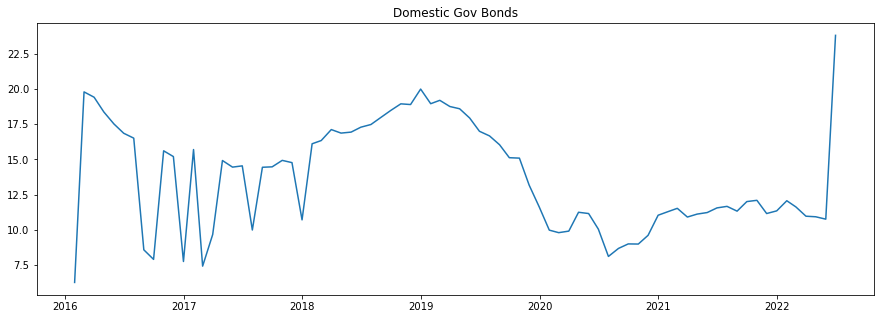

In [6]:
# plotting data

plot_series(data)

In [7]:
# stationarity testing
test_stationarity(data)

Annual Inflation Rate: pvalue = 0.8122072312103654
UK CPI: pvalue = 0.7589486283651402
US CPI: pvalue = 0.999019066643684
EU CPI: pvalue = 1.0
Inf Expect (Households): pvalue = 0.209746588103577
Interest Rate: pvalue = 0.6134987236989533
REER: pvalue = 0.8532141225046872
NEER: pvalue = 0.3246743311061132
Gross Foreign Reserves: pvalue = 0.7613291733853021
Net Foreign Reserves: pvalue = 0.7973080675114169
Interv: pvalue = 0.9978740973141208
Domestic Gov Bonds: pvalue = 0.45140375644430225


Ряди нестаціонарні

# Bagging над VECM

Нестаціонарність рядів змушує застосувати векторну модель корекції помилок (VECM). Водночас ми упираємося в фундаментальні проблеми:
1) Кількість факторів, які можна включити в модель, сильно обмежена, оскільки довжина ряду замала (див. [Прокляття розмірності](https://uk.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D1%82%D1%8F_%D1%80%D0%BE%D0%B7%D0%BC%D1%96%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%96)).

2) Попередні дані містять значну кількість нетипових значень (інфляційний шок 2014-2015 років), а тому можуть нашкодити якості моделі.

3) Складно визначити оптимальні гіперпараметри моделі (максимальний лаг, наявність тренду та/або константи в моделі і т.д.)

Необхідно обрати такий підхід, який дозволить врахувати вплив усіх обраних факторів, але при цьому залишить модель простою. Скористаємося підходом, який має назву bagging, та модифікуємо його для роботи з часовими рядами. Ідея наступна:
1) На кожній ітерації обираємо $k$ випадкових факторів.

2) Визначаємо максимальний лаг $p$.

3) У циклі для обраних факторів та лагу з проміжку від 1 до $p$ визначаємо ранг коінтеграції рядів ($r$). Якщо $r=0$, то не будуємо модель. Якщо $r \neq 0$, то робимо висновок, що ряди коінтегровані.

4) Будуємо VEC-модель з поточним лагом та визначеним рангом коінтеграції.

5) Зберігаємо результати прогнозу для інфляції та облікової ставки на 6 місяців (з липня по грудень).

6) Порівнюємо прогнози моделі з тестовими (інфляція та ставка за липень та серпень).

7) Якщо прогнози відповідають заданим критеріям точності, то зберігаємо результати прогнозу моделі як найкращі.

8) Після останньої ітерації агрегуємо прогнози багатьох моделей, окремо - прогнози лише найкращих. Для кожного місячного прогнозу визначаємо середнє, стандартне відхилення, а також верхню та нижню межу прогнозу (на рівні 2 стандартних відхилень від середнього)

Отже, замість того, щоб будувати одну сильну модель, ми будуємо велику кількість порівняно слабких, тобто застосовуємо <i>ансамблеве навчання</i>

In [106]:
# build our model

all_factors = data.columns.drop(['Annual Inflation Rate', 'Interest Rate'])
true_inflation = [22.2, 23.8] #test values for annual inflation rate
true_intrate = [25.0, 25.0] #test values for interest rate

inflation_predicts = []
intrate_predicts = []
best_inflation_predicts = []
best_intrate_predicts = []

for iteration in range(5000):
    # select random factor(s)
    factors = ['Annual Inflation Rate', 'Interest Rate']
    chosen_factors = np.random.choice(all_factors, size=3, replace=False)
    factors.extend(chosen_factors)
    
    print(f'Iteration #{iteration}')
    clear_output(wait=True)
    
    for maxlag in range(1, 7):
        # cointegration test
        coint_rank_test = vecm.select_coint_rank(data[factors], det_order=0, k_ar_diff=maxlag)
        coint_rank = coint_rank_test.rank
        if coint_rank == 0:
            continue
            
        # build a model
        vecmodel = vecm.VECM(data[factors], k_ar_diff=maxlag, coint_rank=coint_rank, deterministic='ci')
        vecresult = vecmodel.fit()
        
        # predict July and August inflation|interest rate
        inflation_pred = vecresult.predict(2)[:, 0]
        intrate_pred = vecresult.predict(2)[:, 1]
        
        # add to all predicts
        inflation_predicts.append(vecresult.predict(6)[:, 0])
        intrate_predicts.append(vecresult.predict(6)[:, 1])
        
        # choose the best predicts
        inflation_abs_error = np.array(np.abs(true_inflation - inflation_pred))
        intrate_abs_error = np.array(np.abs(true_intrate - intrate_pred))
        if (all(inflation_abs_error <= 2)) and (all(intrate_abs_error <= 4.5)):
            best_inflation_predicts.append(vecresult.predict(6)[:, 0])
            best_intrate_predicts.append(vecresult.predict(6)[:, 1])
            
inflation_predicts = np.array(inflation_predicts)
best_inflation_predicts = np.array(best_inflation_predicts)
intrate_predicts = np.array(intrate_predicts)
best_intrate_predicts = np.array(best_intrate_predicts)
            
print('Done!', f'number of selected models: {len(best_inflation_predicts)}')

Done! number of selected models: 1895


In [107]:
mean_inflation_predicts = np.round(np.mean(inflation_predicts, axis=0), 2)
std_inflation_predicts = np.round(np.std(inflation_predicts, axis=0), 2)
print('Inflation predicts:')
print(f'Mean: {mean_inflation_predicts}')
print(f'STD: {std_inflation_predicts}')
print(f'Upper 2STDs: {mean_inflation_predicts + 2*std_inflation_predicts}')
print(f'Lower 2STDs: {mean_inflation_predicts - 2*std_inflation_predicts}')

Inflation predicts:
Mean: [22.04 23.7  24.01 23.33 23.47 23.56]
STD: [ 3.5   5.44  6.7   7.27  8.66 10.14]
Upper 2STDs: [29.04 34.58 37.41 37.87 40.79 43.84]
Lower 2STDs: [15.04 12.82 10.61  8.79  6.15  3.28]


In [108]:
mean_best_inflation_predicts = np.round(np.mean(best_inflation_predicts, axis=0), 2)
std_best_inflation_predicts = np.round(np.std(best_inflation_predicts, axis=0), 2)
print('Best inflation predicts:')
print(f'Mean: {mean_best_inflation_predicts}')
print(f'STD: {std_best_inflation_predicts}')
print(f'Upper 2STDs: {mean_best_inflation_predicts + 2*std_best_inflation_predicts}')
print(f'Lower 2STDs: {mean_best_inflation_predicts - 2*std_best_inflation_predicts}')

Best inflation predicts:
Mean: [22.02 24.   24.35 23.57 23.82 23.6 ]
STD: [1.04 1.11 2.48 2.74 3.61 4.31]
Upper 2STDs: [24.1  26.22 29.31 29.05 31.04 32.22]
Lower 2STDs: [19.94 21.78 19.39 18.09 16.6  14.98]


In [109]:
mean_intrate_predicts = np.round(np.mean(intrate_predicts, axis=0), 2)
std_intrate_predicts = np.round(np.std(intrate_predicts, axis=0), 2)
print('Interest rate predicts:')
print(f'Mean: {mean_intrate_predicts}')
print(f'STD: {std_intrate_predicts}')
print(f'Upper 2STDs: {mean_intrate_predicts + 2*std_intrate_predicts}')
print(f'Lower 2STDs: {mean_intrate_predicts - 2*std_intrate_predicts}')

Interest rate predicts:
Mean: [28.13 28.71 33.33 36.52 40.75 45.33]
STD: [3.55 5.38 5.41 6.54 7.32 9.53]
Upper 2STDs: [35.23 39.47 44.15 49.6  55.39 64.39]
Lower 2STDs: [21.03 17.95 22.51 23.44 26.11 26.27]


In [110]:
mean_best_intrate_predicts = np.round(np.mean(best_intrate_predicts, axis=0), 2)
std_best_intrate_predicts = np.round(np.std(best_intrate_predicts, axis=0), 2)
print('Best interest rate predicts:')
print(f'Mean: {mean_best_intrate_predicts}')
print(f'STD: {std_best_intrate_predicts}')
print(f'Upper 2STDs: {mean_best_intrate_predicts + 2*std_best_intrate_predicts}')
print(f'Lower 2STDs: {mean_best_intrate_predicts - 2*std_best_intrate_predicts}')

Best interest rate predicts:
Mean: [26.71 25.75 30.87 33.57 38.42 43.41]
STD: [2.04 2.52 3.33 4.53 4.57 5.91]
Upper 2STDs: [30.79 30.79 37.53 42.63 47.56 55.23]
Lower 2STDs: [22.63 20.71 24.21 24.51 29.28 31.59]
